# Flight Price Prediction

In this notebook, we will consider the problem of modelling flight price predicition based on the data from Kaggle website.

## Import Necessary Libraries

First, we need to import the libraries that will be used throughout this notebook.

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
import sys


## Load Datasets

Now, let's load the datasets that we will be using for our analysis.


In [11]:
# Load datasets
business_df = pd.read_csv('../datasets/business.csv')
economy_df = pd.read_csv('../datasets/economy.csv')
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')
business_df.head()
economy_df.head()
clean_dataset.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [12]:
#加距离数据
import pandas as pd
import numpy as np

# 创建字典，包含城市信息
locations = {
    'Delhi': (28.7041, 77.1025),
    'Mumbai': (19.0760, 72.8777),
    'Bangalore': (12.9716, 77.5946),
    'Hyderabad': (17.3850, 78.4867),
    'Kolkata': (22.5726, 88.3639),
    'Chennai': (13.0827, 80.2707)
}

df = pd.read_csv('../datasets/Clean_Dataset.csv')
# 查找DataFrame中唯一的城市名称
source_cities = set(df['source_city'].unique())
destination_cities = set(df['destination_city'].unique())
all_cities = source_cities.union(destination_cities)

# 查找locations字典中缺失的城市
missing_cities = [city for city in all_cities if city not in locations]
print("缺失的城市:", missing_cities)

def haversine(lat1, lon1, lat2, lon2):
    # 将角度转换为弧度
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # 计算经纬度差
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # 应用哈弗赛公式
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # 地球半径大约为6371公里
    km = 6371 * c
    return km

# 读取DataFrame
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')

# 计算每行的距离并添加到新列
clean_dataset['distance'] = clean_dataset.apply(lambda row: haversine(locations[row['source_city']][0],
                                                locations[row['source_city']][1],
                                                locations[row['destination_city']][0],
                                                locations[row['destination_city']][1]), axis=1)

# 查看更新后的DataFrame
clean_dataset.head()

缺失的城市: []


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,distance
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953,1153.241291
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953,1153.241291
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956,1153.241291
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955,1153.241291
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955,1153.241291


In [13]:
clean_dataset.shape
clean_dataset.describe(include='all')

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,distance
count,300153.000000,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000,300153.000000
unique,NaN,6,1561,6,6,3,6,6,2,NaN,NaN,NaN,NaN
top,NaN,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN,NaN
freq,NaN,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN,NaN
mean,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523,1176.732196
std,86646.852011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366,442.080704
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000,290.172025
25%,75038.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000,845.318386
50%,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000,1181.882100
75%,225114.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000,1560.696623


In [14]:
clean_dataset.dropna(inplace=True)
clean_dataset.shape


(300153, 13)

In [15]:
clean_dataset.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
distance            0
dtype: int64

In [16]:
import pandas as pd

# Load the datasets
business_df = pd.read_csv('../datasets/business.csv')
clean_dataset_df = pd.read_csv('../datasets/Clean_Dataset.csv')
economy_df = pd.read_csv('../datasets/economy.csv')

# Ensure the dates are in a consistent format
business_df['date'] = pd.to_datetime(business_df['date'], format='%d-%m-%Y')
economy_df['date'] = pd.to_datetime(economy_df['date'], format='%d-%m-%Y')

# Concatenate the date columns from economy and business
combined_dates = pd.concat([economy_df['date'], business_df['date']], ignore_index=True)

# Ensure the combined_dates has the same length as cleandataset
combined_dates = combined_dates[:len(clean_dataset_df)]

# Add the combined dates to cleandataset
clean_dataset_df['combined_date'] = combined_dates

# Save the updated dataframe to a new CSV
updated_file_path = '../datasets/Clean_Dataset_Updated.csv'
clean_dataset_df.to_csv(updated_file_path, index=False)

print(f"Updated file saved to {updated_file_path}")


Updated file saved to ../datasets/Clean_Dataset_Updated.csv



# Let's visualize the first few rows of the dataset

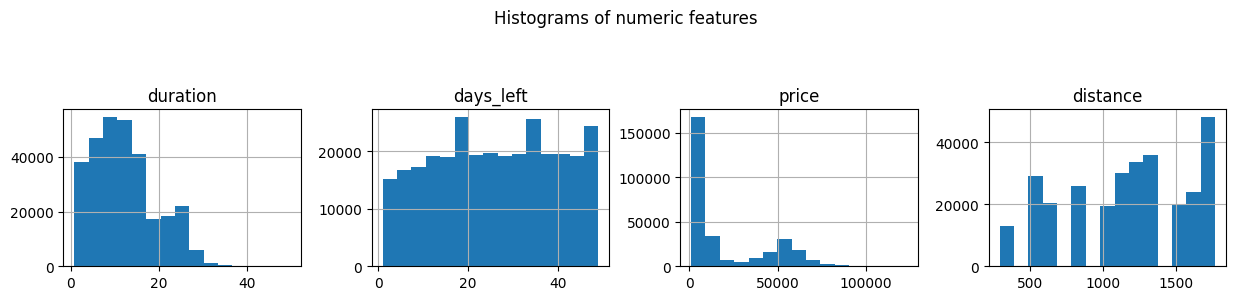

In [17]:
# Plotting histograms for all numeric features to understand distributions
# exclude the unnamed column
clean_dataset.drop('Unnamed: 0', axis=1, inplace=True)
clean_dataset.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.suptitle('Histograms of numeric features')
plt.show()

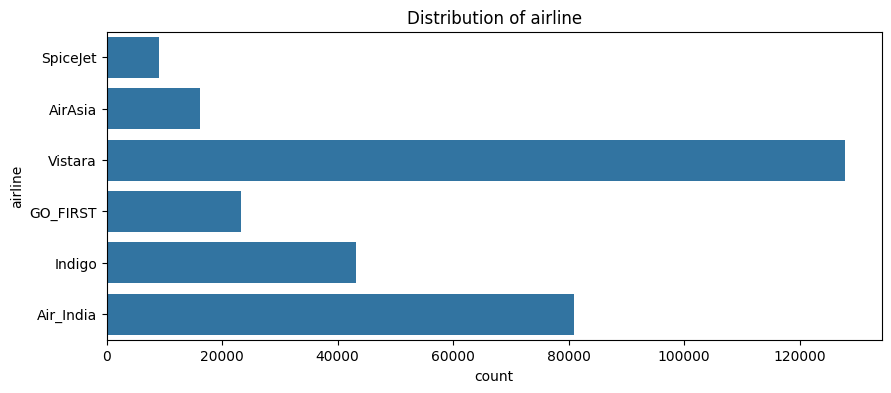

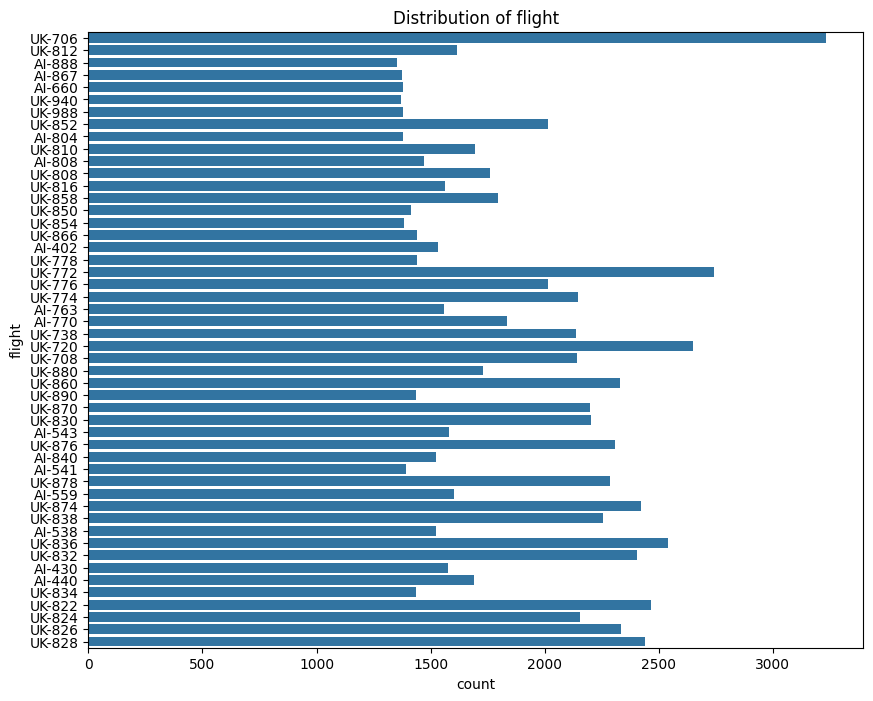

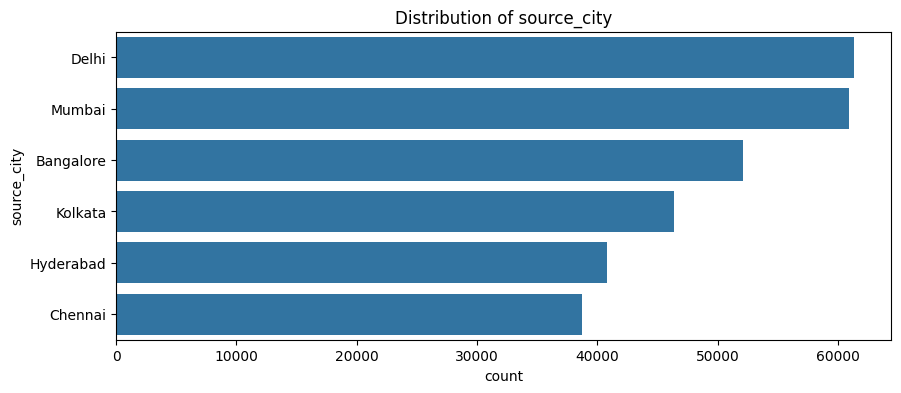

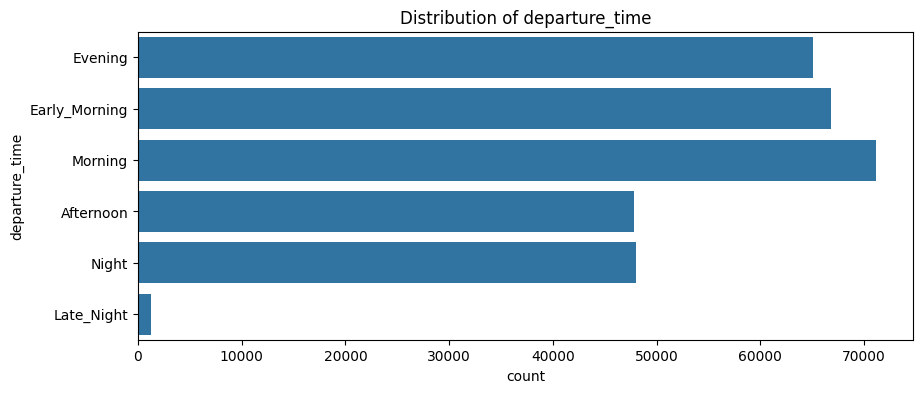

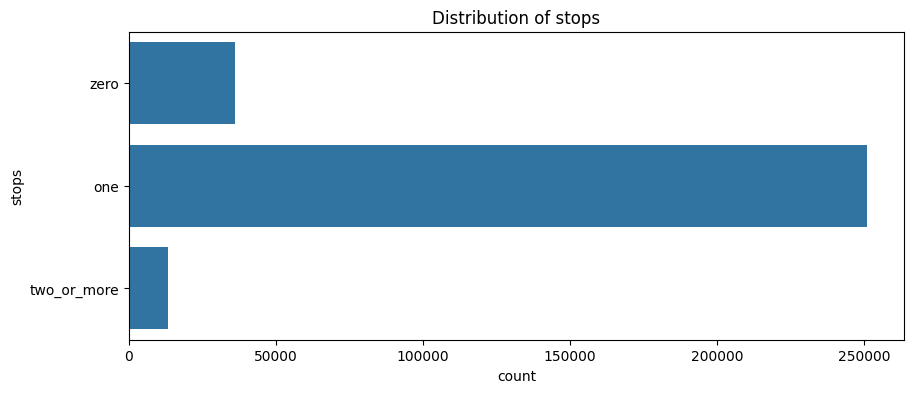

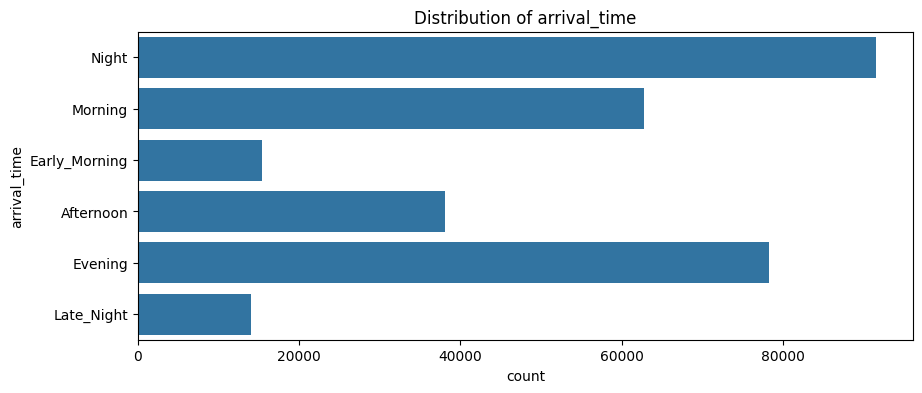

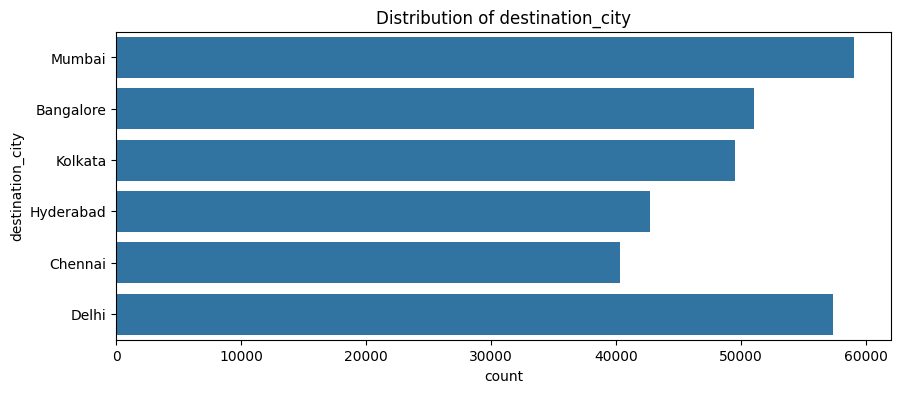

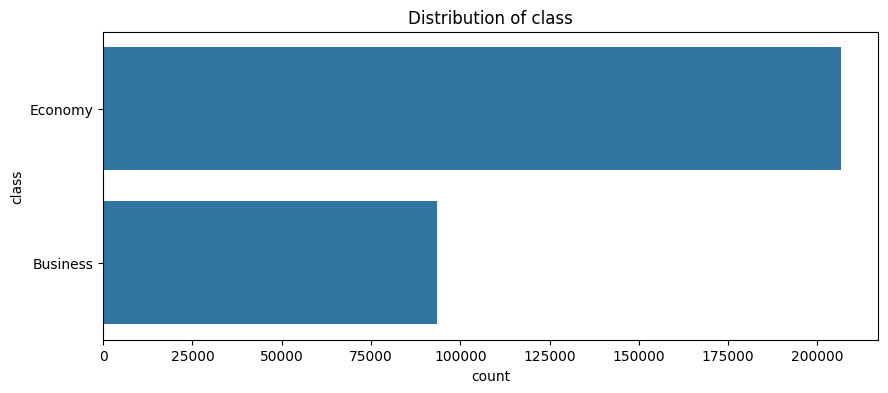

In [18]:
# For categorical data, we can use count plots to understand the distribution of categories
for column in clean_dataset.select_dtypes(include=['object']).columns:
    # Plotting count plots for all categorical features
    # If the number of categories is too high,e.g., flight, we can filter the top 50 categories to make the plot more readable
    if column != 'flight':
        plt.figure(figsize=(10, 4))
        sns.countplot(y=column, data=clean_dataset)
        plt.title(f'Distribution of {column}')
        plt.show()
    else:
        top_categories = clean_dataset[column].value_counts().index[:50]  # Get top 50 categories
        filtered_data = clean_dataset[clean_dataset[column].isin(top_categories)]
        plt.figure(figsize=(10, 8))  
        sns.countplot(y=column, data=filtered_data)
        plt.yticks(fontsize=10)
        plt.title(f'Distribution of {column}')
        plt.show()
        

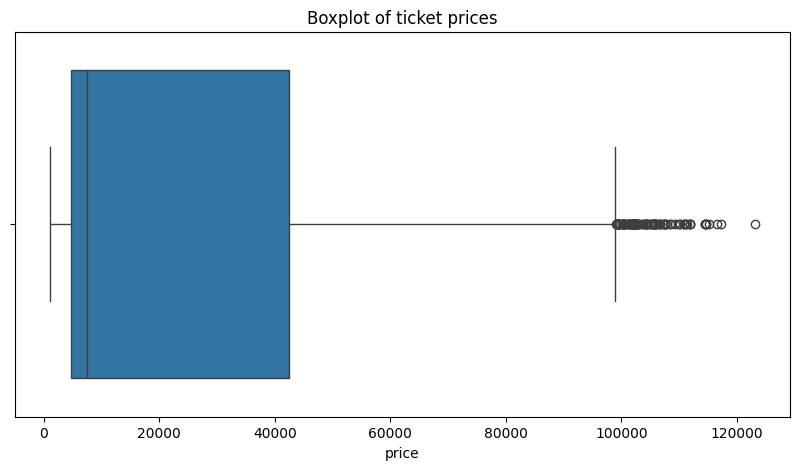

In [19]:
# Boxplot for the price column to see its distribution and spot any outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=clean_dataset['price'])
plt.title('Boxplot of ticket prices')
plt.show()

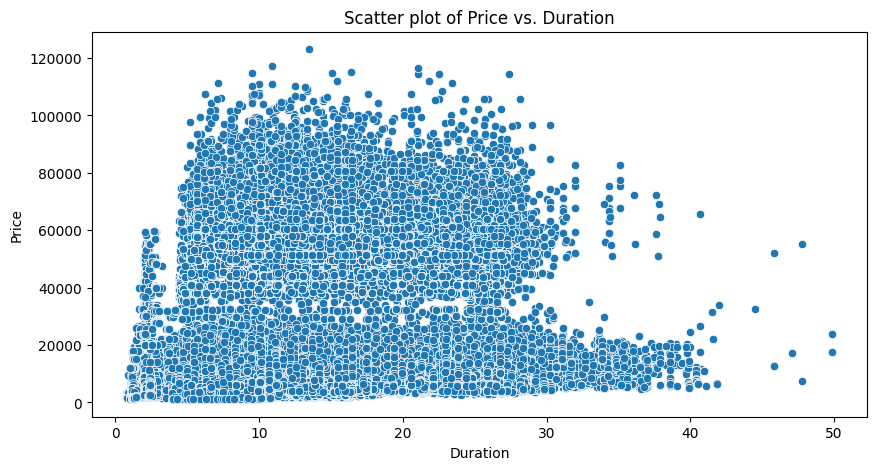

In [20]:
# A scatter plot to visualize the relationship between two variables, for example, price and duration
plt.figure(figsize=(10, 5))
sns.scatterplot(x=clean_dataset['duration'], y=clean_dataset['price'])
plt.title('Scatter plot of Price vs. Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()


In [21]:
# Correlation heatmap to understand the relationships between variables
# Select only the numeric columns for correlation
numeric_dataset = clean_dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_dataset.corr()

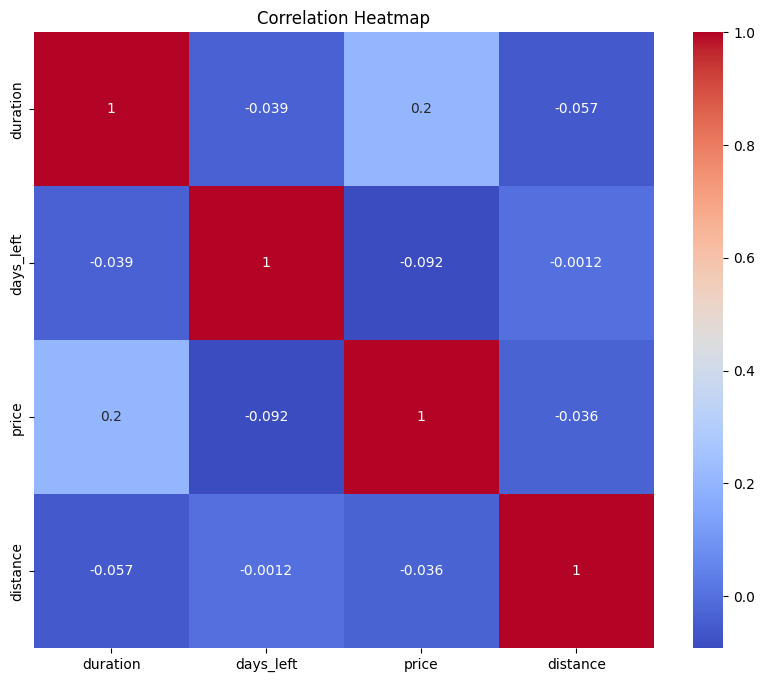

In [22]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='price'>

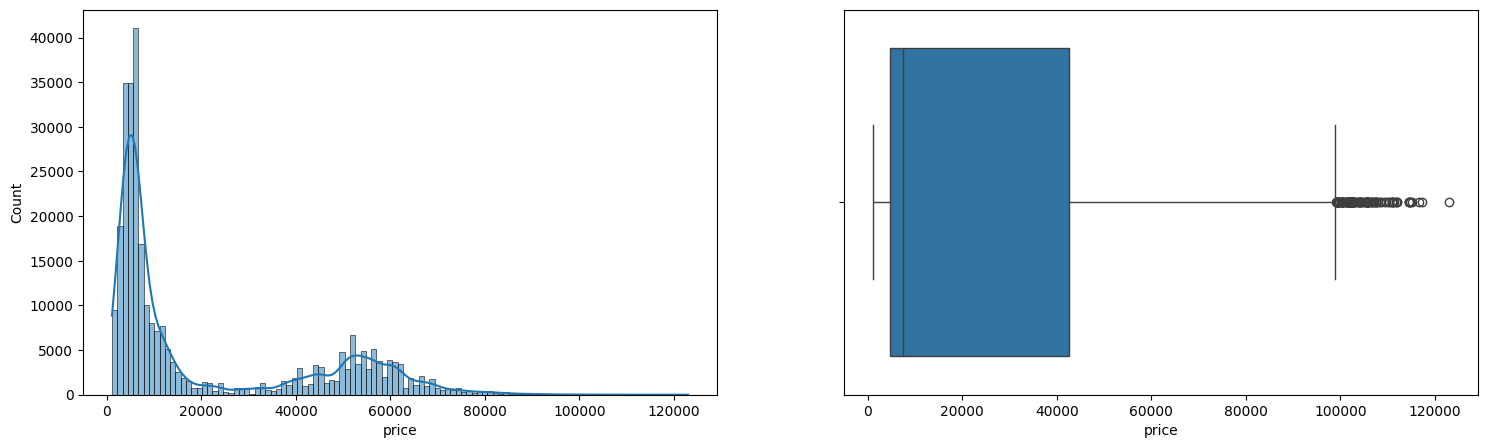

In [23]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.histplot(x = 'price', data = clean_dataset, kde = True)
plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = clean_dataset)

Text(0.5, 1.0, 'Airline prices based on the class and company')

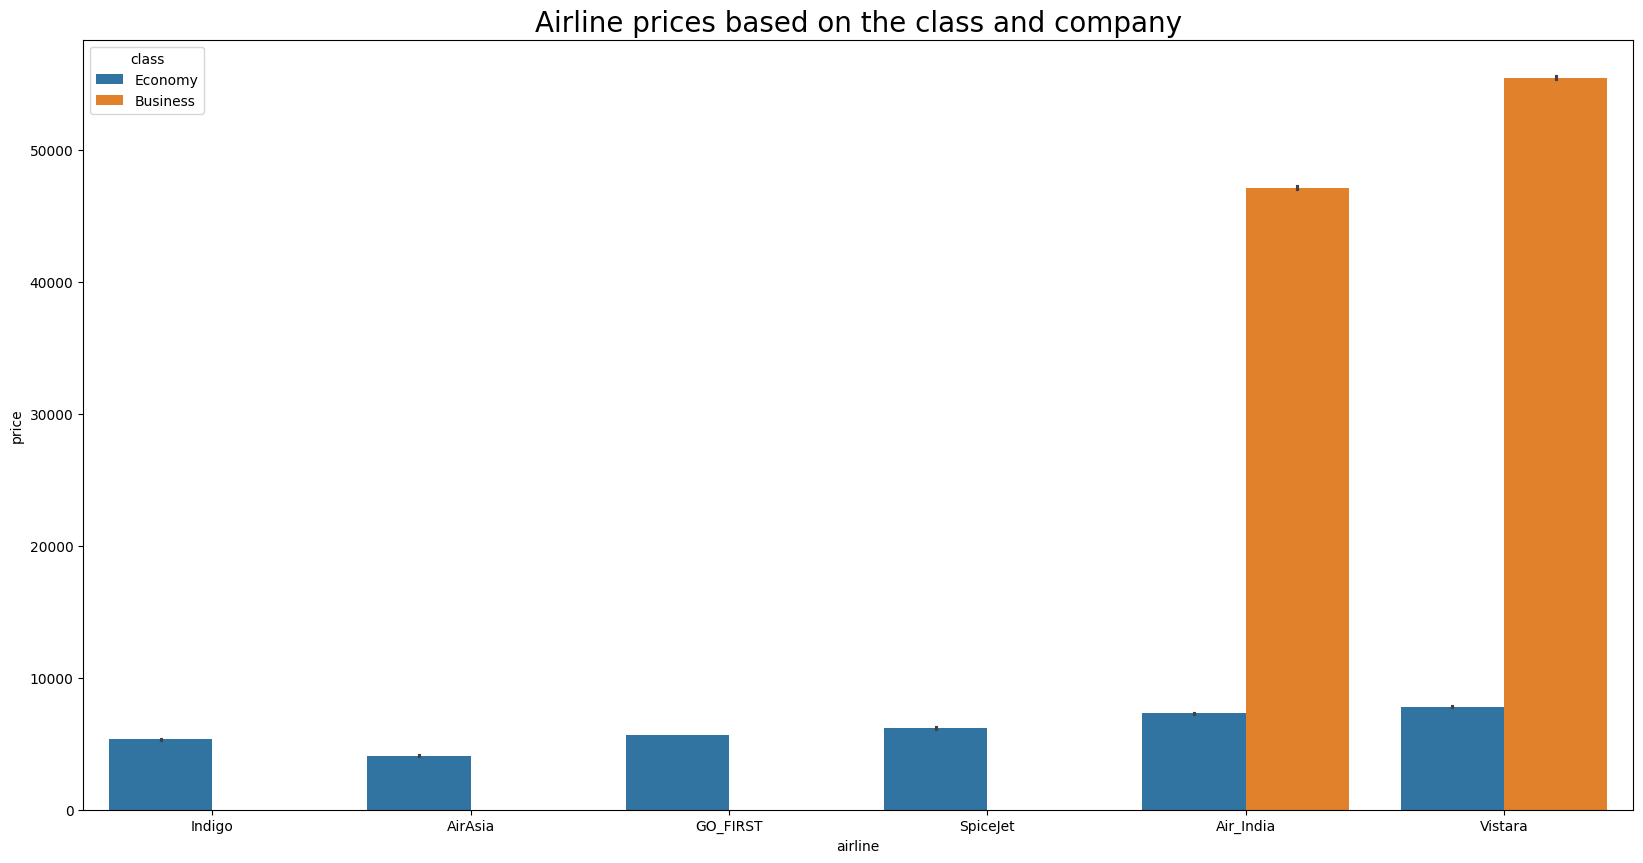

In [24]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=clean_dataset.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

# Make data transformation

In [25]:
transformed_dataset = clean_dataset.copy()
transformed_dataset['Economy'] = clean_dataset['class'] == 'Economy'
transformed_dataset.drop('class', axis=1, inplace=True)

In [26]:
#transformed_dataset['source_city'].unique()

In [27]:
city_size = { # this is for year 2011 - https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population
    'Delhi': 110,
    'Mumbai': 124,
    'Bangalore': 84,
    'Kolkata': 44,
    'Hyderabad': 69,
    'Chennai' : 46
}
transformed_dataset['source_size'] = transformed_dataset['source_city'].replace(city_size)
transformed_dataset.drop('source_city', axis=1, inplace=True)
transformed_dataset['destination_size'] = transformed_dataset['destination_city'].replace(city_size)
transformed_dataset.drop('destination_city', axis=1, inplace=True)

C:\Users\chens\AppData\Local\Temp\ipykernel_11836\2533689888.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transformed_dataset['source_size'] = transformed_dataset['source_city'].replace(city_size)
C:\Users\chens\AppData\Local\Temp\ipykernel_11836\2533689888.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transformed_dataset['destination_size'] = transformed_dataset['destination_city'].replace(city_size)


In [28]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['departure_time','arrival_time'])

In [29]:
stops = {
    'zero': 0,
    'one': 1,
    'two_or_more': 2,
}
transformed_dataset['stops_num'] = transformed_dataset['stops'].replace(stops)
transformed_dataset.drop('stops', axis=1, inplace=True)

C:\Users\chens\AppData\Local\Temp\ipykernel_11836\3828070998.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  transformed_dataset['stops_num'] = transformed_dataset['stops'].replace(stops)


In [30]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['airline'])

In [31]:
transformed_dataset['flight_num'] = pd.factorize(transformed_dataset['flight'])[0]
transformed_dataset.drop('flight', axis=1, inplace=True)

In [32]:
transformed_dataset.head()

,duration,days_left,price,distance,Economy,source_size,destination_size,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,...,arrival_time_Morning,arrival_time_Night,stops_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_num
0,2.17,1,5953,1153.241291,True,110,124,False,False,True,...,False,True,0,False,False,False,False,True,False,0
1,2.33,1,5953,1153.241291,True,110,124,False,True,False,...,True,False,0,False,False,False,False,True,False,1
2,2.17,1,5956,1153.241291,True,110,124,False,True,False,...,False,False,0,True,False,False,False,False,False,2
3,2.25,1,5955,1153.241291,True,110,124,False,False,False,...,False,False,0,False,False,False,False,False,True,3
4,2.33,1,5955,1153.241291,True,110,124,False,False,False,...,True,False,0,False,False,False,False,False,True,4


In [33]:
transformed_dataset.describe()
# output the transformed dataset to a new CSV file
transformed_dataset.to_csv('../datasets/Transformed_Dataset.csv', index=False)

In [34]:
#我想用马尔可夫链试试，以下是代码
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split


# 创建航线和舱位类别的组合标识列
clean_dataset['route_class'] = clean_dataset['source_city'] + '-' + clean_dataset['destination_city'] + '-' + clean_dataset['class']

# 使用KBinsDiscretizer将价格分成几个区间
n_bins = 5  
binning = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
clean_dataset['price_bin'] = binning.fit_transform(clean_dataset[['price']]).astype(int)


max_bin = clean_dataset['price_bin'].max() + 1  # 全数据集中的最大状态数

# 分割数据集为70%训练和30%测试
train_data, test_data = train_test_split(clean_dataset, test_size=0.3, random_state=42, stratify=clean_dataset['route_class'])


# 准备两个字典来存储每条航线的转移矩阵和最常见的初始价格状态
route_class_matrices = {}
route_class_common_initial_states = {}

for route_class in train_data['route_class'].unique():
    sub_df = train_data[train_data['route_class'] == route_class]
    transition_matrix = np.zeros((max_bin, max_bin))
    
    # 计算转移概率矩阵
    for i in range(len(sub_df) - 1):
        current_state = int(sub_df.iloc[i]['price_bin'])
        next_state = int(sub_df.iloc[i + 1]['price_bin'])
        transition_matrix[current_state, next_state] += 1

    # 转换计数为概率
    if transition_matrix.sum(axis=1).all():  # 确保没有除以零的情况
        transition_matrix = transition_matrix / transition_matrix.sum(axis=1, keepdims=True)
    
    route_class_matrices[route_class] = transition_matrix
    # 寻找每个航线最常见的初始价格状态
    most_common_initial_state = np.argmax(sub_df['price_bin'].value_counts().values)
    route_class_common_initial_states[route_class] = most_common_initial_state
    # 测试部分：评估每条航线的模型拟合度
accuracies = {}
for route_class in test_data['route_class'].unique():
    sub_df = test_data[test_data['route_class'] == route_class]
    if route_class in route_class_matrices:
        correct_predictions = 0
        total_predictions = 0
        
        for i in range(len(sub_df) - 1):
            current_state = int(sub_df.iloc[i]['price_bin'])
            next_state = int(sub_df.iloc[i + 1]['price_bin'])
            predicted_state = np.argmax(route_class_matrices[route_class][current_state])
            
            if predicted_state == next_state:
                correct_predictions += 1
            total_predictions += 1
        
        if total_predictions > 0:
            accuracies[route_class] = correct_predictions / total_predictions

# 输出每条航线的模型拟合度
for route_class, accuracy in accuracies.items():
    print(f"航线和舱位 {route_class} 的模型拟合度: {accuracy:.2f}")

c:\Users\chens\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


航线和舱位 Kolkata-Chennai-Business 的模型拟合度: 0.94
航线和舱位 Kolkata-Mumbai-Business 的模型拟合度: 0.81
航线和舱位 Delhi-Mumbai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Bangalore-Business 的模型拟合度: 0.75
航线和舱位 Mumbai-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Delhi-Business 的模型拟合度: 0.50
航线和舱位 Delhi-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Kolkata-Bangalore-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Mumbai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Hyderabad-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Bangalore-Business 的模型拟合度: 0.59
航线和舱位 Chennai-Delhi-Business 的模型拟合度: 0.58
航线和舱位 Hyderabad-Delhi-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Hyderabad-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Chennai-Business 的模型拟合度: 0.59
航线和舱位 Delhi-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Bangalore-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Hyderabad-Chennai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Kolkata-Economy 的模型拟合度: 1.00
航线和舱位 Chennai-Mumbai-Business 的模型拟合度: 0.43
航线和舱位 Delhi-Chennai-Economy 的模型拟合度: 1.00
航线和舱位 Mumbai-Chennai-Business 的模型拟合度: 0.47
航线和舱位 Bangalore-Delhi-Economy 的模型拟合度: 1.0

In [35]:

# 获取价格区间的边界
bin_edges = binning.bin_edges_[0]

# 输出价格预测
for route_class, matrix in route_class_matrices.items():
    initial_state = route_class_common_initial_states[route_class]
    likely_next_state = np.argmax(matrix[initial_state])
    initial_price_range = f"{bin_edges[initial_state]:.2f} to {bin_edges[initial_state + 1]:.2f}"
    next_price_range = f"{bin_edges[likely_next_state]:.2f} to {bin_edges[likely_next_state + 1]:.2f}"
    print(f"航线和舱位 {route_class}:")
    print(f"  最常见的初始价格状态: {initial_state} ({initial_price_range})")
    print(f"  预测的下一个最可能的价格状态: {likely_next_state} ({next_price_range})")
    print()


航线和舱位 Bangalore-Delhi-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Hyderabad-Bangalore-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 2 (49891.40 to 74284.60)

航线和舱位 Chennai-Mumbai-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Mumbai-Kolkata-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Bangalore-Mumbai-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Hyderabad-Mumbai-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 2 (49891.40 to 74284.60)

航线和舱位 Kolkata-Bangalore-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0 (1105.00 to 25498.20)

航线和舱位 Chennai-Hyderabad-Business:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 1 (25498.20 to 49891.40)

航线和舱位 Mumbai-Hyderabad-Economy:
  最常见的初始价格状态: 0 (1105.00 to 25498.20)
  预测的下一个最可能的价格状态: 0

(300153, 9) (300153,)
   duration  days_left    0    1    2    3    4    5    6
0      2.17          1  4.0  2.0  2.0  2.0  5.0  5.0  1.0
1      2.33          1  4.0  2.0  1.0  2.0  4.0  5.0  1.0
2      2.17          1  0.0  2.0  1.0  2.0  1.0  5.0  1.0
3      2.25          1  5.0  2.0  4.0  2.0  0.0  5.0  1.0
4      2.33          1  5.0  2.0  4.0  2.0  4.0  5.0  1.0
0    5953
1    5953
2    5956
3    5955
4    5955
Name: price, dtype: int64
Mean Squared Error: 49200540.29
Mean Absolute Error: 4624.99
R-squared: 0.90
Root Mean Squared Error: 7014.31


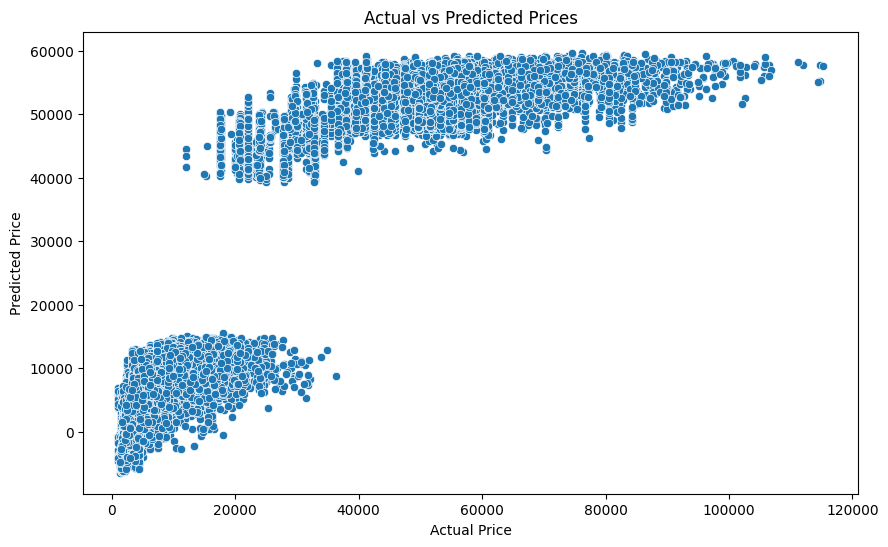

In [36]:
# linear regression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
import pandas as pd
import numpy as np

clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')
ordinalEncoder = OrdinalEncoder()
cate_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
ordinalEncoder_features = ordinalEncoder.fit_transform(clean_dataset[cate_features])
ordinalEncoder_features

# combine the ordinal encoded features with the numeric features
final_features = pd.concat([clean_dataset[['duration', 'days_left', 'price']], pd.DataFrame(ordinalEncoder_features)], axis=1)
final_features

# feature and target variables
X = final_features.drop('price', axis = 1)
y = final_features['price']
print(X.shape, y.shape)
print(X[:5])
print(y[:5])

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# create a linear regression model
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


model = LinearRegression()
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test)
# calculate the mean squared error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')

# calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae:.2f}')

# calculate the R-squared value
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.2f}')

# calculate the root mean squared error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse:.2f}')

# plot the predicted vs actual prices
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()


In [37]:
# linear regression with nerual network
# # 导入必要的库
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # 读取数据
# clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')

# # 使用 OrdinalEncoder 对分类特征进行编码
# ordinalEncoder = OrdinalEncoder()
# cate_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
# ordinalEncoder_features = ordinalEncoder.fit_transform(clean_dataset[cate_features])

# # 将编码后的分类特征与数值特征结合
# encoded_df = pd.DataFrame(ordinalEncoder_features, columns=cate_features)
# final_features = pd.concat([clean_dataset[['duration', 'days_left', 'price']], encoded_df], axis=1)

# # 确保所有列名为字符串类型
# final_features.columns = final_features.columns.astype(str)

# # 特征和目标变量
# X = final_features.drop('price', axis=1)
# y = final_features['price']

# # 将数据分成训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 数据标准化
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # 创建DNN模型
# def create_dnn_model(input_dim):
#     model = Sequential()
#     model.add(Dense(128, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # 输出层
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# # 初始化和训练模型
# dnn_model = create_dnn_model(X_train.shape[1])
# history = dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# # 进行预测
# y_pred = dnn_model.predict(X_test)

# # 评估模型
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Mean Squared Error: {mse:.2f}')
# print(f'Mean Absolute Error: {mae:.2f}')
# print(f'R-squared: {r2:.2f}')
# print(f'Root Mean Squared Error: {rmse:.2f}')

# # 绘制实际价格与预测价格的散点图
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred.flatten())
# plt.xlabel('Actual Price')
# plt.ylabel('Predicted Price')
# plt.title('Actual vs Predicted Prices using DNN')
# plt.show()

# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import pystan
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # 读取数据
# clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')

# # 使用 OrdinalEncoder 对分类特征进行编码
# ordinalEncoder = OrdinalEncoder()
# cate_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
# ordinalEncoder_features = ordinalEncoder.fit_transform(clean_dataset[cate_features])

# # 将编码后的分类特征与数值特征结合
# encoded_df = pd.DataFrame(ordinalEncoder_features, columns=cate_features)
# final_features = pd.concat([clean_dataset[['duration', 'days_left', 'price']], encoded_df], axis=1)

# # 确保所有列名为字符串类型
# final_features.columns = final_features.columns.astype(str)

# # 特征和目标变量
# X = final_features.drop('price', axis=1)
# y = final_features['price']

# # 将数据分成训练集和测试集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # 使用贝叶斯线性回归模型（PGM）进行参数推断
# stan_code = """
# data {
#   int<lower=0> N; // 数据量
#   int<lower=0> K; // 特征数量
#   matrix[N, K] X; // 特征矩阵
#   vector[N] y; // 目标变量
# }
# parameters {
#   vector[K] beta; // 回归系数
#   real alpha; // 截距
#   real<lower=0> sigma; // 噪声标准差
# }
# model {
#   y ~ normal(X * beta + alpha, sigma); // 正态分布
# }
# """

# # 编译模型
# stan_model = pystan.StanModel(model_code=stan_code)

# # 准备数据
# data = {'N': X_train.shape[0], 'K': X_train.shape[1], 'X': X_train, 'y': y_train}

# # 采样
# fit = stan_model.sampling(data=data, iter=1000, chains=4)

# # 从PGMs中提取参数
# params = fit.extract()
# beta_mean = np.mean(params['beta'], axis=0)
# alpha_mean = np.mean(params['alpha'])

# # 将PGMs输出作为特征添加到DNN输入
# X_train_pgm = np.hstack([X_train, X_train @ beta_mean.reshape(-1, 1) + alpha_mean])
# X_test_pgm = np.hstack([X_test, X_test @ beta_mean.reshape(-1, 1) + alpha_mean])

# # 数据标准化
# scaler = StandardScaler()
# X_train_pgm = scaler.fit_transform(X_train_pgm)
# X_test_pgm = scaler.transform(X_test_pgm)

# # 创建DNN模型
# def create_dnn_model(input_dim):
#     model = Sequential()
#     model.add(Dense(128, input_dim=input_dim, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(32, activation='relu'))
#     model.add(Dense(1))  # 输出层
#     model.compile(optimizer='adam', loss='mse', metrics=['mae'])
#     return model

# # 初始化和训练模型
# dnn_model = create_dnn_model(X_train_pgm.shape[1])
# history = dnn_model.fit(X_train_pgm, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# # 进行预测
# y_pred = dnn_model.predict(X_test_pgm)

# # 评估模型
# mse = mean_squared_error(y_test, y_pred)
# mae = mean_absolute_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mse)

# print(f'Mean Squared Error: {mse:.2f}')
# print(f'Mean Absolute Error: {mae:.2f}')
# print(f'R-squared: {r2:.2f}')
# print(f'Root Mean Squared Error: {rmse:.2f}')

# # 绘制实际价格与预测价格的散点图
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=y_test, y=y_pred.flatten())
# plt.xlabel('Actual Price')
# plt.ylabel('Predicted Price')
# plt.title('Actual vs Predicted Prices using DNN with PGM features')
# plt.show()

# 导入必要的库
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# 读取数据
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')

# 使用 OrdinalEncoder 对分类特征进行编码
ordinalEncoder = OrdinalEncoder()
cate_features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']
ordinalEncoder_features = ordinalEncoder.fit_transform(clean_dataset[cate_features])

# 将编码后的分类特征与数值特征结合
encoded_df = pd.DataFrame(ordinalEncoder_features, columns=cate_features)
final_features = pd.concat([clean_dataset[['duration', 'days_left', 'price']], encoded_df], axis=1)

# 确保所有列名为字符串类型
final_features.columns = final_features.columns.astype(str)

# 特征和目标变量
X = final_features.drop('price', axis=1)
y = final_features['price']

# 将数据分成训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 线性特征和非线性特征
linear_features = ['duration', 'days_left']
nonlinear_features = [col for col in X.columns if col not in linear_features]

# 使用贝叶斯线性回归模型（PGM）进行参数推断
stan_code = """
data {
  int<lower=0> N; // 数据量
  int<lower=0> K; // 特征数量
  matrix[N, K] X; // 特征矩阵
  vector[N] y; // 目标变量
}
parameters {
  vector[K] beta; // 回归系数
  real alpha; // 截距
  real<lower=0> sigma; // 噪声标准差
}
model {
  y ~ normal(X * beta + alpha, sigma); // 正态分布
}
"""

# 编译模型
stan_model = pystan.StanModel(model_code=stan_code)

# 准备数据
data = {'N': X_train[linear_features].shape[0], 'K': X_train[linear_features].shape[1], 'X': X_train[linear_features], 'y': y_train}

# 采样
fit = stan_model.sampling(data=data, iter=100, chains=4)

# 从PGMs中提取参数
params = fit.extract()
beta_mean = np.mean(params['beta'], axis=0)
alpha_mean = np.mean(params['alpha'])

# 将PGMs输出作为特征添加到DNN输入
pgm_feature_train = (X_train[linear_features].dot(beta_mean) + alpha_mean).values.reshape(-1, 1)
pgm_feature_test = (X_test[linear_features].dot(beta_mean) + alpha_mean).values.reshape(-1, 1)

X_train_pgm = np.hstack([X_train, pgm_feature_train])
X_test_pgm = np.hstack([X_test, pgm_feature_test])

# 数据标准化
scaler = StandardScaler()
X_train_nonlin = scaler.fit_transform(X_train[nonlinear_features])
X_test_nonlin = scaler.transform(X_test[nonlinear_features])

X_train_combined = np.hstack([X_train_nonlin, pgm_feature_train])
X_test_combined = np.hstack([X_test_nonlin, pgm_feature_test])

# 创建DNN模型
def create_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # 输出层
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# 初始化和训练DNN模型
dnn_model = create_dnn_model(X_train_combined.shape[1])
history = dnn_model.fit(X_train_combined, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 进行预测
y_pred = dnn_model.predict(X_test_combined).flatten()

# 评估模型
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

# 绘制实际价格与预测价格的散点图
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices using Linear Regression + DNN with PGM features')
plt.show()





ModuleNotFoundError: No module named 'pystan'